# Comparative Analysis of Sentiment Analysis Techniques

In this project, we will draw comparisons between traditional statistical analysis tools and cutting-edge AI/ML models. This notebook will examine of the capabilities of SAS against models such as the BERT transformer and LSTM (Long Short-Term Memory) networks.

## Objective

The primary aim is to evaluate and contrast the effectiveness of each method in classifying sentiments expressed in a dataset composed of various tweets. This evaluation will focus on metrics such as accuracy, recall, and precision scores to evaluate each method's performance.

## Approach

1. Create "Gold Standard" testing dataset in TestDaya.ipynb.
2. Import in Tweet Sentiment Extraction train.csv data.
3. Perform Necessary pre-processing.
4. Train a Naive Bayes classifier as a baseline
5. Train a BERT Model and an LSTM Neural Network Model.
6. Test accuracy, precision, and recall on the "Gold Standard" dataset.
7. Analyze results. Explain why one model may work better than others and discuss interpretation of sarcasm and other figurative speech. 

If you are curious about the creation of the Gold Standard dataset, see the file "TestData.ipynb". I will start by importing the necessary libraries and defining necessary functions.

First, I need to import nltk to download some dependencies for lemmatization.

In [55]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/oga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/oga/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Next, import the packages.

In [56]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import emoji
import string

from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from sklearn import preprocessing
import matplotlib.pyplot as plt
# import tensorflow_hub as hub
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np 
import pickle
import os


from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


## Step 2

Now I will now read in the training data and display some basic information about it.

In [57]:
MultiClassTrain = pd.read_csv('Data/TweetSentimentExtraction.csv', encoding='utf-8')
# Display info
print(f"Num rows: {MultiClassTrain.shape[0]}")
MultiClassTrain.head()

Num rows: 27481


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [58]:
MultiClassTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


We have one null Value in the training data lets drop it, and lets drop the unneeded columns.

In [59]:
MultiClassTrain.dropna(inplace=True)
MultiClassTrain = MultiClassTrain.drop(['textID', 'selected_text'], axis=1)
MultiClassTrain.describe()


,text,sentiment
count,27480,27480
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11117


Now let's view the distribution of the classes.

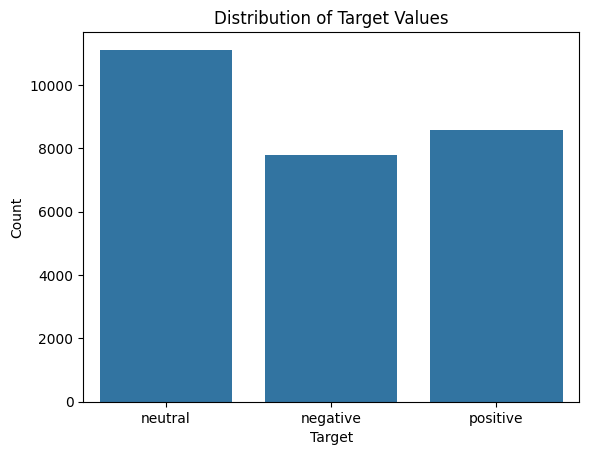

In [60]:
# Plotting the distribution 
sns.countplot(x='sentiment', data=MultiClassTrain)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Now I will read in the "Gold Standard" test data and display the same EDA.

In [61]:
MultiClassTest = pd.read_csv('Data/MultiClassLabeledCustomTwitterSentiments.csv', encoding='utf-8')
# Display info
print(f"Num rows: {MultiClassTest.shape[0]}")
MultiClassTest.head()

Num rows: 410


,text,target
0,I don't know about you but I think Alden Ehren...,4
1,The PR for DLPack support in CuPy has been mer...,4
2,Oh ffs. Such bs. How did he react to recent Co...,0
3,Super cool reimplementation (+ new stuff) of ...,4
4,Now targeting June 1 launch of SES-12 from Pad...,2


In [62]:
MultiClassTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    410 non-null    object
 1   target  410 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ KB


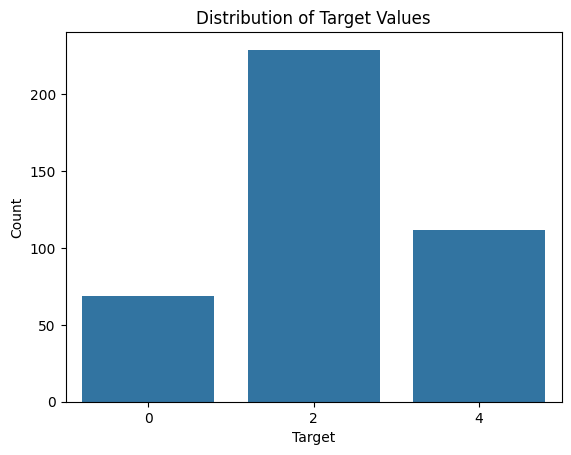

In [63]:
# Plotting the distribution 
sns.countplot(x='target', data=MultiClassTest)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

## Step 3

Now I will perform preprocessing of the data. Below, I have a list of functions that will be ran as a pipeline to preprocess all of the data. The first function is a function to convert all emojis to their english string equivalents. I do this since I read that including rather than removing emojis can increase accuracy. Next, I string all the characters that are not informative (punctuation, links, etc.). I then remove all hashtags from the text, and then remove all illegal characters. Lastly, I remove any back-to-back spaces.

In [64]:
# Function to replace emojis in text with their textual representations
#   Input: String representing a tweet text
#   Output: De-Emojied String
def convert_emoji(text):
    # Use the 'demojize' function from the emoji library
    return emoji.demojize(text, delimiters=("", ""))

#Remove punctuations, links, mentions
def strip_all_entities(text): 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return lemmatized


def run_pipeline(text):
    texts_new = []
    for t in text:
        texts_new.append(remove_mult_spaces(
            # lemmatize_text(
                filter_chars(
                    clean_hashtags(
                        strip_all_entities(
                            convert_emoji(t)
                        )
                    )
                )
            # )
        )
    )
    return texts_new
    

MultiClassTrain["cleaned_text"] = run_pipeline(MultiClassTrain.text)
MultiClassTest["cleaned_text"] = run_pipeline(MultiClassTest.text)

Let's examine the cleaned data

In [65]:
MultiClassTest["cleaned_text"].head()

0    I dont know about you but I think Alden Ehrenr...
1    The PR for DLPack support in CuPy has been mer...
2    Oh ffs Such bs How did he react to recent Cons...
3    Super cool reimplementation new stuff of our d...
4    Now targeting June 1 launch of SES12 from Pad ...
Name: cleaned_text, dtype: object

Below is a visualization of how many words are in each tweet after cleaning the data. 

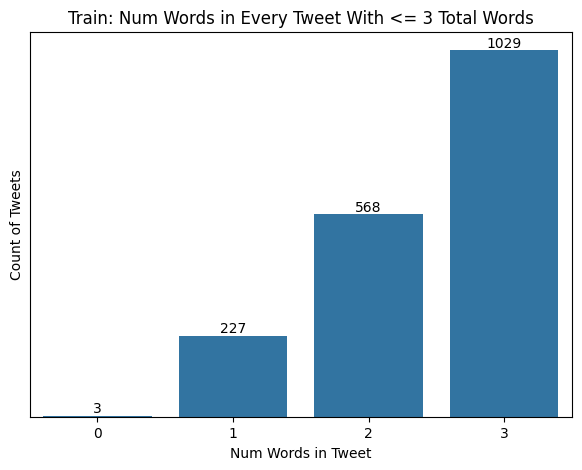

Total Rows: 1827


In [66]:
text_len_threshhold = 3

text_len = []
for text in MultiClassTrain.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

MultiClassTrain['text_len'] = text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=MultiClassTrain[MultiClassTrain['text_len']<=text_len_threshhold])
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count of Tweets')
plt.xlabel('Num Words in Tweet')
plt.title(f'Train: Num Words in Every Tweet With <= {text_len_threshhold} Total Words')
plt.show()

print(f'Total Rows: {MultiClassTrain[MultiClassTrain["text_len"]<=text_len_threshhold].shape[0]}')


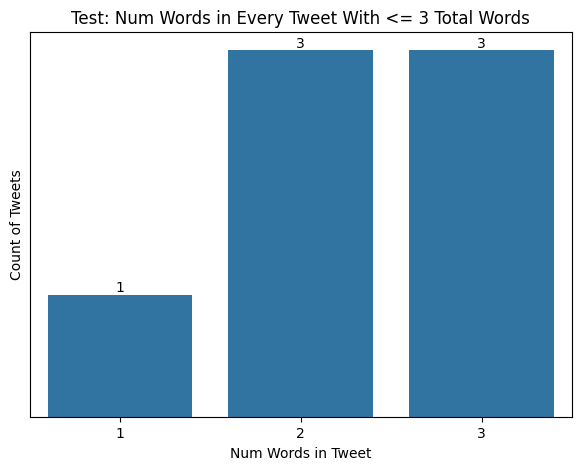

Total Rows: 7


In [67]:
text_len_threshhold = 3

text_len = []
for text in MultiClassTest.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

MultiClassTest['text_len'] = text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=MultiClassTest[MultiClassTest['text_len']<=text_len_threshhold])
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count of Tweets')
plt.xlabel('Num Words in Tweet')
plt.title(f'Test: Num Words in Every Tweet With <= {text_len_threshhold} Total Words')
plt.show()

print(f'Total Rows: {MultiClassTest[MultiClassTest["text_len"]<=text_len_threshhold].shape[0]}')


As you can see, there are 3 empty tweets after cleaning, and there are 1,827 total entries with 3 or less words. We will go ahead and remove all these rows to increase accuracy. 

In [68]:
print(f'Total training rows before removing: {MultiClassTrain.shape[0]}')
print(f'Total testing rows before removing: {MultiClassTest.shape[0]}')

MultiClassTrain = MultiClassTrain[MultiClassTrain["text_len"] > text_len_threshhold]
MultiClassTest = MultiClassTest[MultiClassTest["text_len"] > text_len_threshhold]

print(f'Total training rows after removing: {MultiClassTrain.shape[0]}')
print(f'Total testing rows after removing: {MultiClassTest.shape[0]}')

Total training rows before removing: 27480
Total testing rows before removing: 410
Total training rows after removing: 25653
Total testing rows after removing: 403


Now, lets tokenize these cleaned tweets. This is necessary to use the BERT Model later. Below, I will tokenize all the tweets and display a distribution of the lengths of the tokenized tweets.

MAX TOKENIZED SENTENCE LENGTH: 54


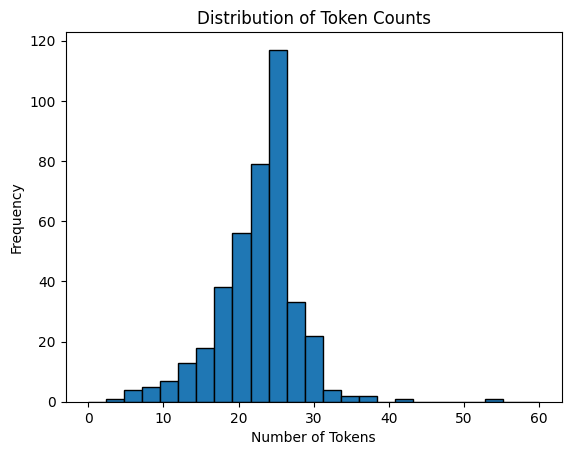

Average token count: 22.464019851116625


In [69]:
# TODO: tokenize test data too
# Initialize the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
def token_distribution(texts):
    # Tokenize each text and count the tokens, with tqdm for progress tracking
    token_counts = [len(tokenizer.tokenize(text)) for text in texts]

    print(f"MAX TOKENIZED SENTENCE LENGTH: {np.max(token_counts)}")
    
    # Plot the distribution of token counts up to 800
    plt.hist(token_counts, bins=25, range=(0,60), edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Counts')
    plt.show()
    
    # Calculate the average token count excluding the counts over 800
    average_token_count = sum(token_counts) / len(token_counts) if token_counts else 0
    print(f"Average token count: {average_token_count}")
    
    # Return the average token count for texts with 800 tokens or less
    return average_token_count

average_length_in_tokens = token_distribution(MultiClassTest['cleaned_text'].tolist())

TODO: talk about significance of token length.

Now lets look at the distribution of classes across the data.

In [70]:
# MultiClassTest['target'] = MultiClassTest['target'].map({'negative':0, 'neutral':2, 'positive':4})
MultiClassTest['target'].value_counts()

target
2    227
4    107
0     69
Name: count, dtype: int64

As you can see, the classes are biased towards class 2 (positive). I will use Oversampling to balance the data.

In [71]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(MultiClassTest['cleaned_text']).reshape(-1, 1), np.array(MultiClassTest['target']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['cleaned_text', 'sentiment'])
train_os['sentiment'].value_counts()

sentiment
4    227
0    227
2    227
Name: count, dtype: int64

## Step 4

Now I will train a Naive Bayes Classifier as a baseline model to compare against. The Naive Bayes is built by first tokenizing the data using CountVectorizer, then taking the tokenized data and turning them into TF-IDF scores, and then fitting on those scores.

In [72]:
X = train_os['cleaned_text'].values
y = train_os['sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

X_test = MultiClassTest['cleaned_text'].values
y_test = MultiClassTest['target'].values

y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

encoder = preprocessing.OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1))
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)
X_valid_cv = clf.transform(X_valid)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)
X_valid_tf = tf_transformer.transform(X_valid_cv)

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)


MultinomialNB()

In [73]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(MultinomialNB(), X_train_tf, y_train_le, cv=5)
print("Cross-validated scores:", scores)

Cross-validated scores: [0.77235772 0.74796748 0.79508197 0.75409836 0.7295082 ]


Now let's examine the results:

In [74]:

nb_pred = nb_clf.predict(X_valid_tf)
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_valid_le,nb_pred, target_names=['negative', 'neutral', 'positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    negative       0.72      1.00      0.84        23
     neutral       1.00      0.39      0.56        23
    positive       0.82      1.00      0.90        23

    accuracy                           0.80        69
   macro avg       0.85      0.80      0.77        69
weighted avg       0.85      0.80      0.77        69



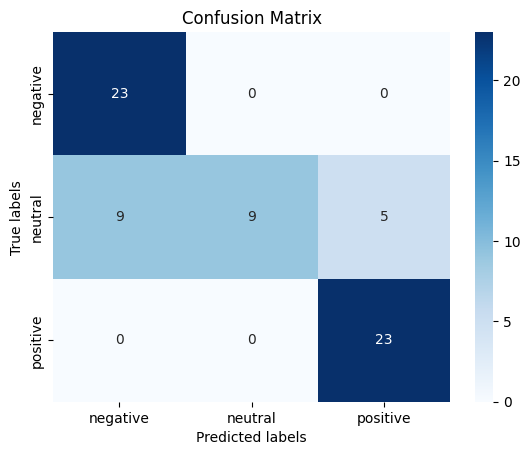

In [75]:
cm = confusion_matrix(y_valid_le, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

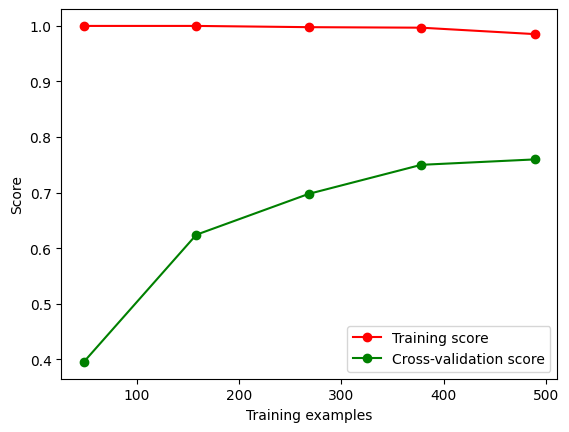

In [76]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(MultinomialNB(), X_train_tf, y_train_le, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()


From ChatGPT:  

1. Training Score: The training score is consistently high across the number of training examples. This indicates that the classifier is performing well on the training set.
2. Cross-Validation Score: The cross-validation score is increasing with the number of training examples, which is a good sign. It starts at a lower score with a small number of training examples but improves significantly as more data is added. It is still increasing slightly at the largest number of training examples, suggesting that it might continue to improve with even more data.
3. Gap Between Scores: There is a noticeable gap between the training and cross-validation scores. However, this gap is not widening as more training examples are added. Instead, the cross-validation score seems to be catching up with the training score, which implies the model is generalizing better as it sees more data.

/Users/oga/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


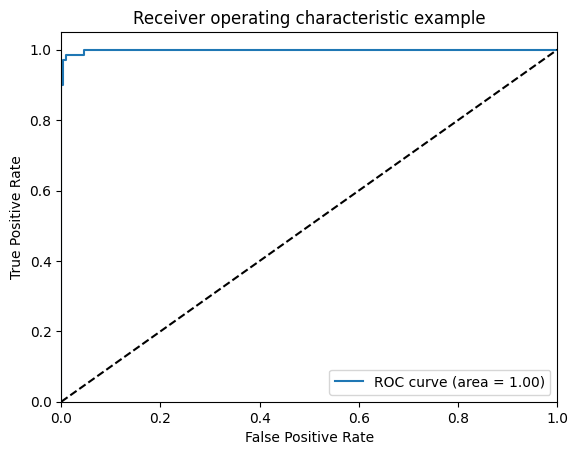

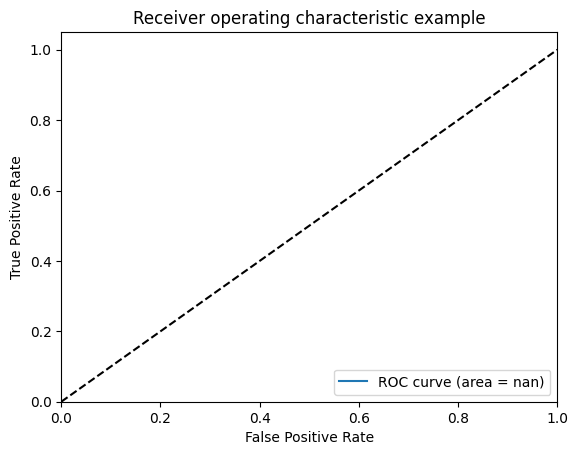

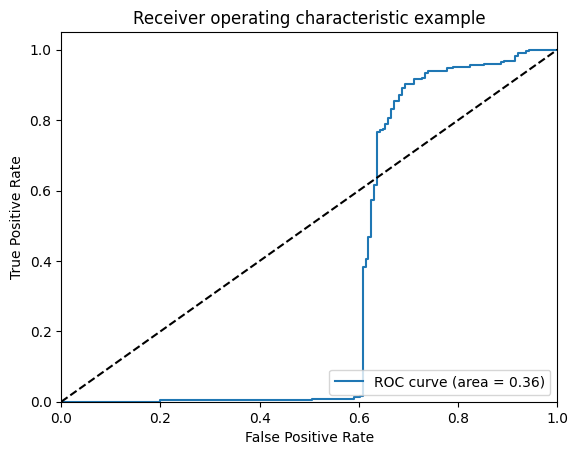

In [77]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Binarize the labels
y_bin = label_binarize(y_test_le, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(MultinomialNB())
y_score = classifier.fit(X_train_tf, y_train_le).predict_proba(X_test_tf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

TODO: Discuss findings

## Step 5

Now I will build and train the BERT model.

In [78]:
MAX_LEN=128
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
# test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [79]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [80]:
model = create_model(bert_model, MAX_LEN)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [81]:
# print(f'ytrain: {type(y_train)} yvalid: {type(y_valid)}')

# y_train_dense = tf.sparse.to_dense(y_train)
# y_valid_dense = tf.sparse.to_dense(y_valid)

# type(y_train_dense)
# type(y_valid_dense)

history_bert = model.fit([train_input_ids,train_attention_masks], y_train.toarray(), validation_data=([val_input_ids,val_attention_masks], y_valid.toarray()), epochs=4, batch_size=32)


Epoch 1/4


2024-04-23 13:21:20.944699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 69s 3s/step - loss: 1.1096 - categorical_accuracy: 0.4134 - val_loss: 1.0818 - val_categorical_accuracy: 0.4928
Epoch 2/4
20/20 [==============================] - 44s 2s/step - loss: 0.9325 - categorical_accuracy: 0.5605 - val_loss: 1.0588 - val_categorical_accuracy: 0.5217
Epoch 3/4
20/20 [==============================] - 42s 2s/step - loss: 0.7837 - categorical_accuracy: 0.6879 - val_loss: 0.7980 - val_categorical_accuracy: 0.5797
Epoch 4/4
20/20 [==============================] - 43s 2s/step - loss: 0.6875 - categorical_accuracy: 0.7565 - val_loss: 0.6580 - val_categorical_accuracy: 0.7246


IDEA: FEED BERT EMBEDDINGS INTO XGBOOST

use only 400